In [45]:
# Import Libraries
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
# Pre-processing
import kardiasclean
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
# NN
import tensorflow as tf
import pickle

## Part 1: Load Data

In [46]:
# Load Data
path2 = Path("../database/clean2")
df = pd.read_csv(path2 / "db_patient.csv")
df.head()

,patient_id,gender,age_days,weight_kg,height_cm,cx_previous,date_birth,date_procedure,rachs,stay_days,expired
0,0,0,3942,35.0,134.0,0,2001-08-22,2012-04-08,1,2,0
1,1,1,3202,18.0,117.0,0,2003-09-19,2012-11-08,1,2,0
2,2,0,3147,22.0,120.0,0,2003-11-21,2012-08-18,1,2,0
3,3,0,4005,42.0,147.0,0,2001-10-07,2012-08-25,1,2,0
4,4,0,5289,40.0,157.0,0,1997-12-22,2012-01-09,1,3,0


In [47]:
# Select feature columns for clustering
columns = [
    "patient_id",
    "gender",
    "age_days", 
    "weight_kg", 
    "height_cm", 
    "cx_previous",
    "rachs",
    "stay_days", # to be dropped
    "expired", # to be dropped
]
# df = df[df['expired'] == 0]
df = df[columns]
df.head()

,patient_id,gender,age_days,weight_kg,height_cm,cx_previous,rachs,stay_days,expired
0,0,0,3942,35.0,134.0,0,1,2,0
1,1,1,3202,18.0,117.0,0,1,2,0
2,2,0,3147,22.0,120.0,0,1,2,0
3,3,0,4005,42.0,147.0,0,1,2,0
4,4,0,5289,40.0,157.0,0,1,3,0


In [48]:
# Load additional columns: Diagnosis
diagnosis_df = pd.read_csv("../database/clean3/main_diagnosis_categories.csv")
diagnosis_df = diagnosis_df.rename(columns={"categories":"category_diagnosis"})
diagnosis_df.dropna(inplace=True)
diagnosis_df.head()

,patient_id,diagnosis_main,category_diagnosis
0,0,Comunicacion interauricular secundum,CIA
1,1,Comunicacion interauricular secundum,CIA
2,2,Comunicacion interauricular secundum,CIA
3,3,Comunicacion interauricular secundum,CIA
4,4,Comunicacion interauricular secundum,CIA


In [49]:
# Load additional columns: Procedures
procedure_df = pd.read_csv("../database/clean3/db_patient_surgical_procedure_category.csv")
procedure_df.dropna(inplace=True)
procedure_df.head()

,patient_id,surgical_procedure,category_procedure
0,0,Reparacion de CIA parche,Parche comunicacion interauricular CIA
1,1,Reparacion de CIA parche,Parche comunicacion interauricular CIA
2,2,Reparacion de CIA parche,Parche comunicacion interauricular CIA
3,3,Reparacion de CIA parche,Parche comunicacion interauricular CIA
4,4,Reparacion de CIA parche,Parche comunicacion interauricular CIA


## Part 2: Pre-Processing

In [50]:
# Bin all Columns by Quantile (aim for top 10)
THRESHOLD = 0.975
low, high = kardiasclean.perform_frequency_split_quantile(diagnosis_df['category_diagnosis'], THRESHOLD)
print(kardiasclean.evaluate_distribution(high, low))

diagnosis_df["category_diagnosis"] = kardiasclean.perform_binning_quantile(diagnosis_df["category_diagnosis"], THRESHOLD, bin_name="Other_Diagnosis")
encoded_diagnosis_df = kardiasclean.perform_matrix_encoding(diagnosis_df["category_diagnosis"], diagnosis_df["patient_id"], append_name=False)
print(encoded_diagnosis_df.shape)
encoded_diagnosis_df.head()

Total data (repeated): 1997
--------------------
Unique high frequency data: 9
Unique low frequency data: 336
--------------------
Total high frequency data: 1331
Total low frequency data: 666
--------------------
Percentage of high data: 66.65%
Percentage of low data: 33.35%
--------------------
Summary
--------------------
From 1997 data, 9 account for 66.65% of the total count.

(1003, 11)


,patient_id,CIA,CIV,Estenosis,PCA,Other_Diagnosis,Coartacion Aortica,Tetralogia de Fallot,Atresia,Post-Surgical Procedure,Hipoplasia
0,0,1,0,0,0,0,0,0,0,0,0
1,1,1,0,0,0,0,0,0,0,0,0
2,2,1,0,0,0,0,0,0,0,0,0
3,3,1,0,0,0,0,0,0,0,0,0
4,4,1,0,0,0,0,0,0,0,0,0


In [51]:
# Bin all Values by scalar (aim for Top 10)
THRESHOLD = 40
OTHER_NAME = "Other_Procedure"
procedure_df["category_procedure"] = procedure_df["category_procedure"].str.replace("Other", OTHER_NAME)
procedure_df["category_procedure"] = kardiasclean.perform_binning_scalar(procedure_df["category_procedure"], THRESHOLD, bin_name=OTHER_NAME)
encoded_procedure_df = kardiasclean.perform_matrix_encoding(procedure_df["category_procedure"], procedure_df["patient_id"], append_name=False)
print(encoded_procedure_df.shape)
encoded_procedure_df.head()

(1003, 11)


,patient_id,Parche comunicacion interauricular CIA,Vena cava inferior parche,Other_Procedure,Cierre de Conducto Arterioso,Reparacion de Canal AV,Reparacion de Tetralogia de Fallot,Procedimiento de Glenn,Reparacion de arco aortico,Fistula sistemico pulmonar,Procedimiento de Fontan
0,0,1,0,0,0,0,0,0,0,0,0
1,1,1,0,0,0,0,0,0,0,0,0
2,2,1,0,0,0,0,0,0,0,0,0
3,3,1,0,0,0,0,0,0,0,0,0
4,4,1,0,0,0,0,0,0,0,0,0


In [52]:
# Merge Patient Data with Diagnosis Data
merged_df = pd.merge(df, encoded_diagnosis_df, on="patient_id")
print(merged_df.shape)
merged_df.head()

(1003, 19)


,patient_id,gender,age_days,weight_kg,height_cm,cx_previous,rachs,stay_days,expired,CIA,CIV,Estenosis,PCA,Other_Diagnosis,Coartacion Aortica,Tetralogia de Fallot,Atresia,Post-Surgical Procedure,Hipoplasia
0,0,0,3942,35.0,134.0,0,1,2,0,1,0,0,0,0,0,0,0,0,0
1,1,1,3202,18.0,117.0,0,1,2,0,1,0,0,0,0,0,0,0,0,0
2,2,0,3147,22.0,120.0,0,1,2,0,1,0,0,0,0,0,0,0,0,0
3,3,0,4005,42.0,147.0,0,1,2,0,1,0,0,0,0,0,0,0,0,0
4,4,0,5289,40.0,157.0,0,1,3,0,1,0,0,0,0,0,0,0,0,0


In [53]:
# Merge Patient and Diagnosis Data with Surgical Procedure Data
merged_df = pd.merge(merged_df, encoded_procedure_df, on="patient_id")
print(merged_df.shape)
print(merged_df.columns)
merged_df.head()

(1003, 29)
Index(['patient_id', 'gender', 'age_days', 'weight_kg', 'height_cm',
       'cx_previous', 'rachs', 'stay_days', 'expired', 'CIA', 'CIV',
       'Estenosis', 'PCA', 'Other_Diagnosis', 'Coartacion Aortica',
       'Tetralogia de Fallot', 'Atresia', 'Post-Surgical Procedure',
       'Hipoplasia', 'Parche comunicacion interauricular CIA',
       'Vena cava inferior parche', 'Other_Procedure',
       'Cierre de Conducto Arterioso', 'Reparacion de Canal AV',
       'Reparacion de Tetralogia de Fallot', 'Procedimiento de Glenn',
       'Reparacion de arco aortico', 'Fistula sistemico pulmonar',
       'Procedimiento de Fontan'],
      dtype='object')


,patient_id,gender,age_days,weight_kg,height_cm,cx_previous,rachs,stay_days,expired,CIA,...,Parche comunicacion interauricular CIA,Vena cava inferior parche,Other_Procedure,Cierre de Conducto Arterioso,Reparacion de Canal AV,Reparacion de Tetralogia de Fallot,Procedimiento de Glenn,Reparacion de arco aortico,Fistula sistemico pulmonar,Procedimiento de Fontan
0,0,0,3942,35.0,134.0,0,1,2,0,1,...,1,0,0,0,0,0,0,0,0,0
1,1,1,3202,18.0,117.0,0,1,2,0,1,...,1,0,0,0,0,0,0,0,0,0
2,2,0,3147,22.0,120.0,0,1,2,0,1,...,1,0,0,0,0,0,0,0,0,0
3,3,0,4005,42.0,147.0,0,1,2,0,1,...,1,0,0,0,0,0,0,0,0,0
4,4,0,5289,40.0,157.0,0,1,3,0,1,...,1,0,0,0,0,0,0,0,0,0


Scaler

## NN

In [54]:
# Features and Target
y = merged_df["expired"]
X = merged_df.drop(columns=["stay_days", "patient_id", "expired"])
X.shape

(1003, 26)

In [55]:
# Split train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
# Normalize
scaler = StandardScaler()
X_scaler = scaler.fit(X)

# Store Model
path = Path("./models")
with open(path / f"nn_scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)

with open(path / f"nn_scaler.pkl", "rb") as f:
    scaler = pickle.load(f)

X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

print(X_train_scaled.shape, X_test_scaled.shape)

(752, 26) (251, 26)


In [56]:
# Define the model - deep neural net, i.e., the number of input features and hidden nodes for each layer.
dim = len(X_train_scaled[0])
nn = tf.keras.models.Sequential()

# First hidden layer
nn.add(tf.keras.layers.Dense(units=40, activation="relu", input_dim=dim))
# Second hidden layer
# nn.add(tf.keras.layers.Dense(units=60, activation="linear"))
# Third hidden layer
# nn.add(tf.keras.layers.Dense(units=60, activation="tanh"))
# Output layer
nn.add(tf.keras.layers.Dense(units=1, activation="relu"))

# Check the structure of the model
nn.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 40)                1080      
                                                                 
 dense_5 (Dense)             (None, 1)                 41        
                                                                 
Total params: 1,121
Trainable params: 1,121
Non-trainable params: 0
_________________________________________________________________


In [57]:
# Train
optimizer = tf.keras.optimizers.Adam(0.0001) # set learning rate
# LOSS: binary_crossentropy, mean_squared_error
nn.compile(
    loss="binary_crossentropy",
    optimizer=optimizer,
    metrics=["accuracy", tf.keras.metrics.Recall()]
)
fit_model = nn.fit(X_train_scaled, y_train, epochs=100, verbose=1)

Epoch 1/100
24/24 [==============================] - 1s 2ms/step - loss: 2.6853 - accuracy: 0.7301 - recall_2: 0.5556
Epoch 2/100
24/24 [==============================] - 0s 2ms/step - loss: 2.5125 - accuracy: 0.7434 - recall_2: 0.4722
Epoch 3/100
24/24 [==============================] - 0s 2ms/step - loss: 2.3160 - accuracy: 0.7447 - recall_2: 0.4722
Epoch 4/100
24/24 [==============================] - 0s 2ms/step - loss: 2.1831 - accuracy: 0.7500 - recall_2: 0.4167
Epoch 5/100
24/24 [==============================] - 0s 2ms/step - loss: 2.1245 - accuracy: 0.7527 - recall_2: 0.4167
Epoch 6/100
24/24 [==============================] - 0s 2ms/step - loss: 2.0341 - accuracy: 0.7553 - recall_2: 0.4167
Epoch 7/100
24/24 [==============================] - 0s 2ms/step - loss: 2.0050 - accuracy: 0.7620 - recall_2: 0.4167
Epoch 8/100
24/24 [==============================] - 0s 3ms/step - loss: 1.9652 - accuracy: 0.7646 - recall_2: 0.4167
Epoch 9/100
24/24 [==============================] - 0s 

In [64]:
# Evaluate the model using the test data
model_loss, model_accuracy, model_recall = nn.evaluate(X_test_scaled, y_test, verbose=2)
print(f"Loss: {model_loss}\nAccuracy: {model_accuracy}\nRecall: {model_recall}")

8/8 - 0s - loss: 0.6100 - accuracy: 0.9402 - recall_2: 0.1000 - 44ms/epoch - 5ms/step
Loss: 0.6100428104400635
Accuracy: 0.9402390718460083
Recall: 0.10000000149011612


In [59]:
from sklearn.metrics import confusion_matrix

y_pred = nn.predict(X_test_scaled)
y_pred = np.asarray([1 if x >= 0.5 else 0 for x in y_pred])
y_pred[y_pred == 1]

8/8 [==============================] - 0s 2ms/step


array([1, 1, 1, 1, 1, 1, 1])

<AxesSubplot:title={'center':'loss'}>

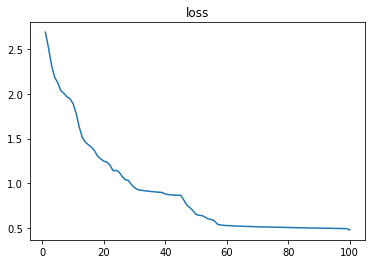

In [60]:
%matplotlib inline
# view loss function
history_df = pd.DataFrame(fit_model.history, index=range(1,len(fit_model.history["loss"])+1))
history_df['loss'].plot(title="loss")

	            	Predicted True	        Predicted False
	Actually True	128 (True Positives)	5 (False Negatives)
	Actually False	6 (False Positives)	111 (True Negatives)

In [61]:
matrix = confusion_matrix(y_test, y_pred)
matrix
true_positive = tp = matrix[0][0]
false_negative = fn = matrix[0][1]
false_positive = fp = matrix[1][0]
true_negative = tn = matrix[1][1]
matrix

array([[235,   6],
       [  9,   1]])

In [62]:
cm_df = pd.DataFrame(
    matrix, 
    index=["Actual 0 (No Mortality)", "Actual 1 (Mortality)"], 
    columns=["Predicted 0 (No Mortality)", "Predicted 1 (Mortality)"]
)
cm_df

,Predicted 0 (No Mortality),Predicted 1 (Mortality)
Actual 0 (No Mortality),235,6
Actual 1 (Mortality),9,1
